In [11]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install mne --upgrade

In [ ]:
pip install signal-processing

In [ ]:
pip install autoreject

In [ ]:
!pip install sklearn.cross_validation

In [ ]:
pip install matplotlib==3.1.1


In [ ]:
import mne,os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import metrics
import pandas as pd
from glob import glob
import random
from signal_processing import *
from cmath import nan
from autoreject import get_rejection_threshold
from autoreject import AutoReject

**Start**

Data Set **A**

Extracting parameters from /content/drive/My Drive/drdo/subjects/VP002/nback1.vhdr...
Setting channel info structure...
Reading 0 ... 704799  =      0.000 ...   704.799 secs...


<ipython-input-15-37a667f4ebcd>:2: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(path_file_vhdr, eog=('HEOG', 'VEOG'), preload=True)  # read raw data of the subject
<ipython-input-15-37a667f4ebcd>:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(TUB_montage)
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # array has the wrong kind or shape, raise the error during one-at-a-time


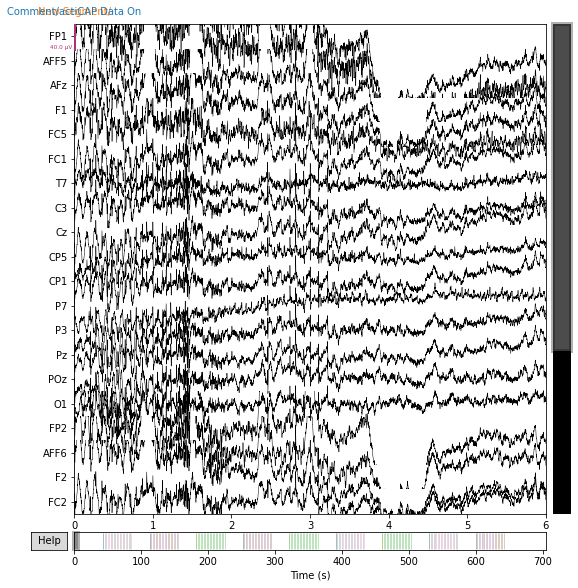

Finding 'sfreq' from header file: /content/drive/My Drive/drdo/subjects/VP002/nback1.vhdr
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 8449 samples (33.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished


1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Created an SSP operator (subspace dimension = 1)


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # array has the wrong kind or shape, raise the error during one-at-a-time


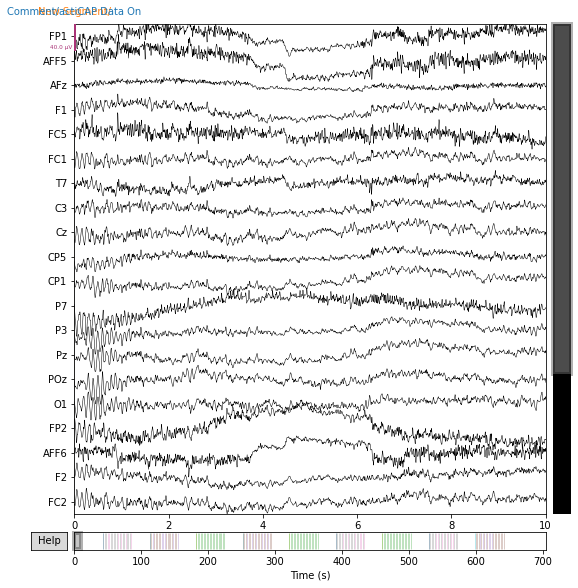

times
[-6.86913366e-22 -4.51282519e-06 -7.95220701e-06 ... -3.86142066e-06
 -2.44550558e-06 -1.22228886e-21]
Fitting ICA to data using 28 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 27 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 20.5s.
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (27 components)
    Zeroing out 0 ICA components
    Projecting back using 28 PCA components
after >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # array has the wrong kind or shape, raise the error during one-at-a-time


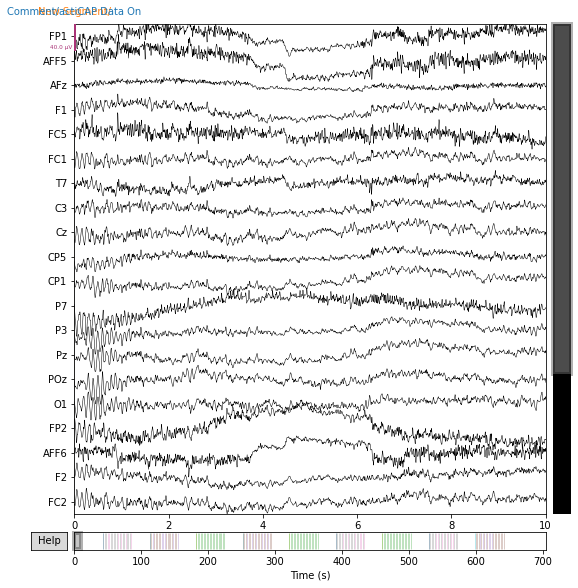

Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S 16', 'Stimulus/S 48', 'Stimulus/S 64', 'Stimulus/S 80', 'Stimulus/S 96', 'Stimulus/S112', 'Stimulus/S128', 'Stimulus/S144']
Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 48', 'Stimulus/S 64', 'Stimulus/S 80', 'Stimulus/S 96', 'Stimulus/S112', 'Stimulus/S128', 'Stimulus/S144']
Not setting metadata
189 matching events found
Setting baseline interval to [-0.30078125, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 189 events and 513 original time points ...
0 bad epochs dropped
Not setting metadata
189 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


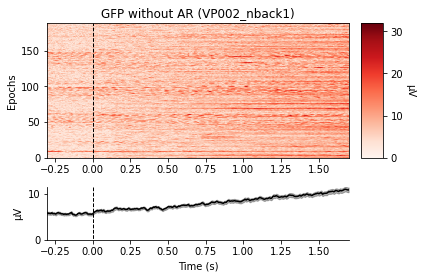

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00010015446830799422}
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/28 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/28 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/189 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/189 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/189 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/189 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/189 [00:00<?,       ?it/s]

Dropped 16 epochs: 8, 60, 86, 88, 92, 93, 95, 96, 97, 104, 132, 140, 141, 142, 145, 186
log >>>>>>>>>>>>>>>


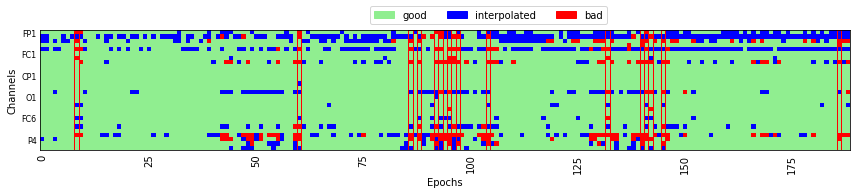

epoches >>>>>>>>>>>>>>>>
Not setting metadata
173 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


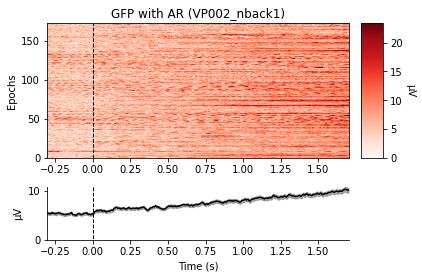

Number of events,173
Events,Stimulus/S 16: 46Stimulus/S 48: 18Stimulus/S 64: 41Stimulus/S 80: 18Stimulus/S 96: 41Stimulus/S112: 3Stimulus/S128: 3Stimulus/S144: 3
Time range,-0.301 – 1.699 sec
Baseline,-0.301 – 0.000 sec


Not setting metadata
46 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
49 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
Not setting metadata
18 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
41 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
Created an SSP operator 

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # array has the wrong kind or shape, raise the error during one-at-a-time


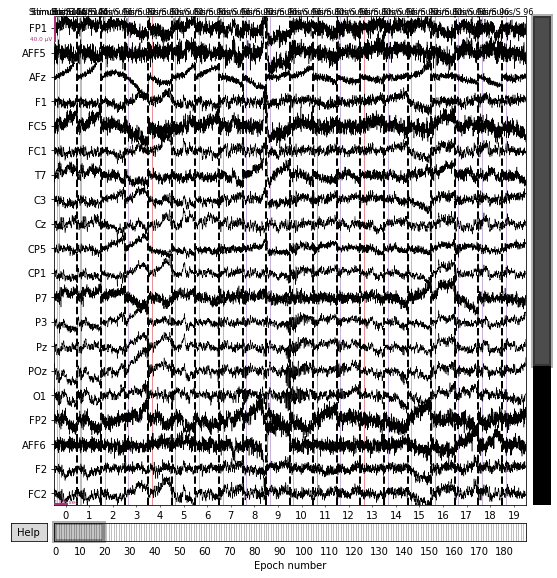

<ipython-input-15-37a667f4ebcd>:137: RuntimeWarning: This filename (/content/drive/My Drive/drdo/preprocess_data//0_back/VP002_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne.Epochs.save(epochs_0_back,fname=back_0_filepath,overwrite=True)
<ipython-input-15-37a667f4ebcd>:138: RuntimeWarning: This filename (/content/drive/My Drive/drdo/preprocess_data//2_back/VP002_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne.Epochs.save(epochs_1_back,fname=back_1_filepath,overwrite=True)
<ipython-input-15-37a667f4ebcd>:139: RuntimeWarning: This filename (/content/drive/My Drive/drdo/preprocess_data//3_back/VP002_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne.Epochs.save(epochs_2_back,fname=back_2_filepath,overwrite=True)


In [24]:
# subjectData = "/content/drive/My Drive/drdo/subjects"
cleanData = "/content/drive/My Drive/drdo/preprocess_data"
fname= "/content/drive/My Drive/drdo/channel_loc.csv"
TUB_montage = mne.channels.read_custom_montage(fname)
# path_file_vhdr1 = '/content/drive/My Drive/drdo/subjects/VP001/nback1.vhdr'
# path_file_vmrk1 = '/content/drive/My Drive/drdo/subjects/VP001/nback1.vmrk'
# preprocess_datasetA(path_file_vhdr1, path_file_vmrk1, "VP001", "nback1")
path_file_vhdr1 = '/content/drive/My Drive/drdo/subjects/VP002/nback1.vhdr'
path_file_vmrk1 = '/content/drive/My Drive/drdo/subjects/VP002/nback1.vmrk'
preprocess_datasetA(path_file_vhdr1, path_file_vmrk1, "VP002", "nback1")

# read_datasetA(subjectData)

In [ ]:
fname= "/content/drive/My Drive/drdo/channel_loc.csv"
# Read a montage from a file.
TUB_montage = mne.channels.read_custom_montage(fname)

def read_datasetA(subjectPath):
    
    try:
        root, dirs, files = next(os.walk(subjectPath))
        
        for folder_name in dirs:
          path_file_vhdr1 = subjectPath + '/' + folder_name + '/nback1.vhdr'
          path_file_vmrk1 = subjectPath + '/' + folder_name + '/nback1.vmrk'
          preprocess_datasetA(path_file_vhdr1, path_file_vmrk1, folder_name, "nback1")

          path_file_vhdr2 = subjectPath + '/' + folder_name + '/nback2.vhdr'
          path_file_vmrk2 = subjectPath + '/' + folder_name + '/nback2.vmrk'
          preprocess_datasetA(path_file_vhdr2, path_file_vmrk2, folder_name, "nback2")

          path_file_vhdr3 = subjectPath + '/' + folder_name + '/nback3.vhdr'
          path_file_vmrk3 = subjectPath + '/' + folder_name + '/nback3.vmrk'
          preprocess_datasetA(path_file_vhdr3, path_file_vmrk3,folder_name,"nback3")
            
    except StopIteration:
        pass
        print("Error ocurred:")
        print("Directory with dataset does not found!")
        print("Program will be terminated")
        exit(1)


In [15]:
def preprocess_datasetA(path_file_vhdr, path_file_vmrk, subject_name , session_name):
  raw = mne.io.read_raw_brainvision(path_file_vhdr, eog=('HEOG', 'VEOG'), preload=True)  # read raw data of the subject
  raw.set_montage(TUB_montage)
  if (raw.info['nchan'] == 4):
    raw = raw.drop_channels(['EOG'])  # EOG channel is deleted
  # read annotations from a file.
  raw.info
  raw.plot(start=0, duration=6)
  mrk = mne.read_annotations(path_file_vmrk, sfreq='auto', uint16_codec=None)
  raw_downsampled = raw.copy().resample(sfreq=256)
  raw_filtered = raw_downsampled.copy().filter(l_freq=0.1 , h_freq= 45)
  raw_notch_filtered = raw_filtered.notch_filter(50, filter_length='auto', phase='zero')

  eog_projs, _ = mne.preprocessing.compute_proj_eog(raw_notch_filtered,verbose=False,n_grad=0,n_mag=0,n_eeg=1,reject=None,no_proj=True,ch_name=['HEOG', 'VEOG'])
  raw_notch_filtered.add_proj(eog_projs,remove_existing=True)
  raw_notch_filtered.apply_proj()
  raw_notch_filtered.drop_channels(['HEOG', 'VEOG']) # later remove this from filter funct
  # raw_notch_filtered.plot()  
  raw_re_referenced = mne.set_eeg_reference(raw_notch_filtered, ref_channels='average', copy=True, projection=False) 
  finData, times = raw_re_referenced[:]
  finData.plot()
  print("times")
  print(times)
  # fig, ax = plt.subplots(2)
  # # raw.plot_psd(ax=ax[0], show = False, fmax = 60)
  # finData.plot_psd(ax=ax[1], show = False, fmax=60)
  # ax[0].set_title("PSD before filtering")
  # ax[1].set_title("PSD after filtering")
  # ax[1].set_xlabel('Frequency(Hz)')
  # fig.set_tight_layout(True)
  # plt.show()
  n_components = 27 #number of components you want to fit # can be either integer which typically implies number of channels - 1 (if applied average reference)
  #     #if floating point number (0-1) fraction of total explained variance
  method = 'fastica'
  max_iter = 100
  fit_params = dict(fastica_it = 5)
  random_state = 42
  ica = mne.preprocessing.ICA(n_components = n_components,
                              method = method,
                              max_iter=max_iter,
                              random_state= random_state)
  ica.fit(finData)
  finData.load_data()
  # ica.plot_sources(finData, show_scrollbars=False)
  # ica.plot_components(sphere=1)
  ica.exclude = []
  reconst_raw = finData.copy()
  # # find which ICs match the EOG pattern
  # eog_indices, eog_scores = ica.find_bads_eog(finData, threshold = 2.5)
  # ica.exclude = eog_indices
  ica.apply(reconst_raw)
  # #print(eog_indices)
  print("after >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
  reconst_raw.plot(title="Automatic")

  events_loaded = mne.events_from_annotations(raw)

  tmin=-0.3 # when does the epoch start relative to the event onset # 300ms before the start of the event
  tmax=1.7  # when does the event end after the even onset # 500 ms from the start of the event

  # #Is a tuple containing the start of the baseline and end of the baseline
  baseline= (None, 0) #None mean begnining of the event and 0 is the start of the event 
  event_ids = {
      'Stimulus/S 16': 16,
      'Stimulus/S 48': 48,
      'Stimulus/S 64': 64,
      'Stimulus/S 80': 80,
      'Stimulus/S 96': 96,
      'Stimulus/S112': 112,
      'Stimulus/S128': 128,
      'Stimulus/S144': 144,
  }

  events,event_ids = mne.events_from_annotations(reconst_raw, event_ids)

  epochs = mne.Epochs(reconst_raw, 
                      events=events,
                      event_id=event_ids,
                      tmin=tmin,tmax=tmax, 
                      baseline=baseline,
                      preload=True,event_repeated = 'drop')
  # epochs = mne.Epochs(reconst_raw,buttontarget_events,event_id=event_dict,tmin=tminmax[0],tmax=tminmax[1],
  #                           baseline=baseline,picks=picks,preload=True)
        
  # Plot the epochs' GFP plot before artefact rejection
  name = subject_name + "_" + session_name
  epochs.plot_image(title="GFP without AR ({})".format(name))

  # Use AutoReject to repair and remove epochs which are artefactual
  reject_criteria = get_rejection_threshold(epochs)
  print('Dropping epochs with rejection threshold:',reject_criteria)
  epochs.drop_bad(reject=reject_criteria)

  ar = AutoReject(thresh_method='random_search',random_state=42)
  ar.fit(epochs)
  epochs_ar, reject_log = ar.transform(epochs, return_log=True)

  print("log >>>>>>>>>>>>>>>")
  reject_log.plot('horizontal')
  print("epoches >>>>>>>>>>>>>>>>")
   # Plot the epochs' GFP after artefact rejection
  # epochs_ar.average().plot()
  epochs_ar.plot_image(title="GFP with AR ({})".format(name))
   # Display the final epochs object meta-data
  display(epochs_ar)


  # export_dir = cleanData + "/" + subject_name

  # Segmnented the epochsin low, medium and high
  back_0_list = [mne.EpochsArray(epochs_ar['Stimulus/S 16'], epochs_ar.info), mne.EpochsArray(epochs_ar['Stimulus/S112'], epochs_ar.info)]
  epochs_0_back = mne.concatenate_epochs(back_0_list)
  back_1_list = [mne.EpochsArray(epochs_ar['Stimulus/S 48'], epochs_ar.info), mne.EpochsArray(epochs_ar['Stimulus/S 64'], epochs_ar.info),  mne.EpochsArray(epochs_ar['Stimulus/S128'], epochs_ar.info)]
  epochs_1_back = mne.concatenate_epochs(back_1_list)
  back_2_list = [mne.EpochsArray(epochs_ar['Stimulus/S 80'], epochs_ar.info), mne.EpochsArray(epochs_ar['Stimulus/S 96'], epochs_ar.info),  mne.EpochsArray(epochs_ar['Stimulus/S144'], epochs_ar.info)]
  epochs_2_back = mne.concatenate_epochs(back_2_list)

  epochs.plot(events=events, event_id = event_ids)

  export_dir = cleanData + "/"

  if session_name == "nback1":
    session_id = "1"
  elif session_name == "nback2":
    session_id = "2"
  else:
    session_id = "3"
  # try:
  #   os.makedirs(export_dir)
  # except FileExistsError:
  #   pass
  try:
    # save the segmented epochs in the clean data directory 
    back_0_filepath = export_dir + "/0_back" + "/" +subject_name + "_"+session_id +".fif"
    back_1_filepath = export_dir + "/2_back" + "/" +subject_name + "_"+session_id +".fif"
    back_2_filepath = export_dir + "/3_back" + "/" +subject_name + "_"+session_id +".fif"
    mne.Epochs.save(epochs_0_back,fname=back_0_filepath,overwrite=True)
    mne.Epochs.save(epochs_1_back,fname=back_1_filepath,overwrite=True)
    mne.Epochs.save(epochs_2_back,fname=back_2_filepath,overwrite=True)
  except FileExistsError:
    pass
